## Terminologie 

**Nombres pseudo-aléatoires**: consiste en une suite de nombre ayant certaines propriétés mathématiques. Après une certaine période, on revient au debut de la suite. Le but est que la période soit la plus longue possible et la répartition la plus uniforme possible.

**Nombres vraiment aléatoires**: Ils sont générés via un facteur externe tel que les mouvements de souris, la pression atmosphérique,...

## Génération de nombre pseudo aléatoires 
### Distribution uniforme (entre 0 et 1)

#### Modulo 

$$
    i_{n+1} = (a i_n + c) \% M
$$

**keypoint** : la distribution devient plus uniforme si $a$ et $M$ sont grands. $a$ doit être assez différent de $M$ sinon on génère tout le temps le même nombre.

(array([4., 1., 0., 5., 6., 0., 2., 2., 1., 2., 2., 1., 3., 2., 6., 5., 9.,
        4., 2., 8., 3., 4., 1., 6., 3., 5., 4., 4., 2., 3.]),
 array([7.11367779e-08, 3.29879096e-02, 6.59757481e-02, 9.89635866e-02,
        1.31951425e-01, 1.64939264e-01, 1.97927102e-01, 2.30914941e-01,
        2.63902779e-01, 2.96890618e-01, 3.29878456e-01, 3.62866295e-01,
        3.95854133e-01, 4.28841972e-01, 4.61829810e-01, 4.94817649e-01,
        5.27805487e-01, 5.60793326e-01, 5.93781164e-01, 6.26769003e-01,
        6.59756841e-01, 6.92744680e-01, 7.25732518e-01, 7.58720357e-01,
        7.91708195e-01, 8.24696034e-01, 8.57683872e-01, 8.90671711e-01,
        9.23659549e-01, 9.56647388e-01, 9.89635226e-01]),
 <a list of 30 Patch objects>)

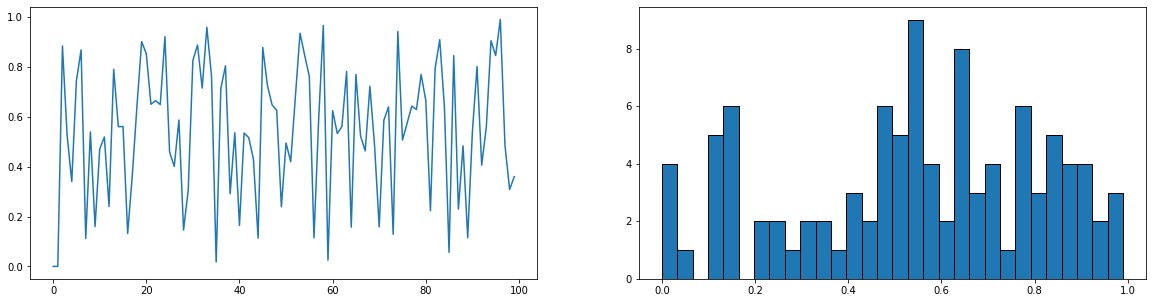

In [38]:
import matplotlib.pyplot as plt

def random_modulo(n, seed = 1, a = 7, c = 0, M = 17):
    i_k = seed
    for k in range(n):
        i_k = ((a*i_k) + c) % M
        yield i_k/M
        
random_list = list(random_modulo(n = 100, seed=1, a=3523, c=50, M=2.6794**25))

plt.rcParams["figure.figsize"] = (20, 5)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(100), random_list)
ax2.hist(random_list, bins=30, ec ="black")

### Distribution arbitraire 

**But**: transformer une distribution uniforme en une distribution arbitraire

#### Méthode de rejet :

On prend une fonction $f$ qui sera la forme de notre distribution (ex: $e^{-x^2/2}$)

On tire chaque fois 2 nombres :

- un nombre $x_0$ qui appartient au domaine de $f$. 

/!\ Si le domaine est infini, on doit faire un changement de variable pour passer en domaine fini.

- un nombre $y$ compris entre $0$ et $M$ (max de $f$).

Si $y \geq f(x_0)$, on le rejette. Sinon on le garde.

<img src="http://blog.mir.dlang.io/images/figures/random/rejection_sampling.svg" width="500px">

**Efficacité**: $E = \frac{\text{nombre de points gardés}}{\text{nombre de points tirés}} = \frac{\int_a^b f(x)dx}{M(b-a)}$

Par conséquent, plus la forme de la fonction est piquée, moins cette méthode est efficace.

**Problème**: manque d'efficacité.

efficacité (sqrt): 66.78%
efficacité (gaussienne): 15.77%


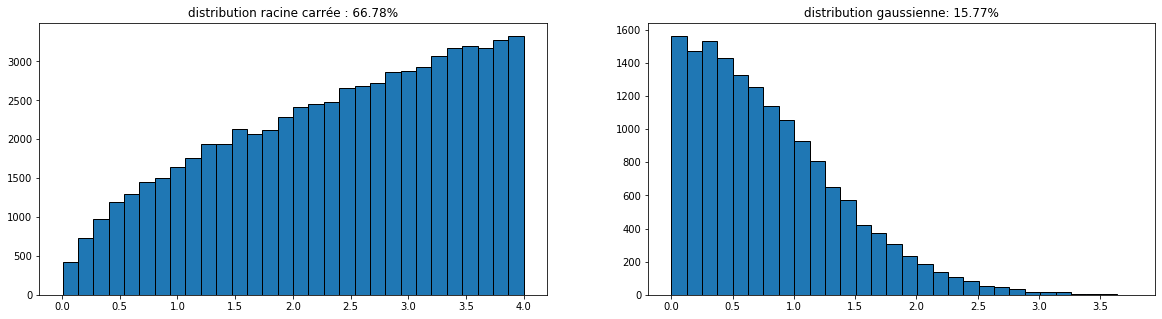

In [51]:
import numpy as np
import random
import math

def gaussian(x) :
    return math.exp(-(x**2) / 2)

"""
f : fonction
n : nombre de nombres à générer
a : borne inférieure
b : borne supérieure
"""
def rejet(f, n, a, b, M):
    numbers = []
    accepted = 0
    for i in range(n):
        x = random.uniform(a, b)
        y = random.uniform(0, M)
        
        # on ne garde pas le nombre
        if (y >= f(x)):
            continue
        
        # on garde le nombre
        numbers.append(x)
        accepted += 1
        
    return numbers, accepted/n

numbers_sqrt, eff_sqrt = rejet(math.sqrt, n = 100000, a=0, b=4, M=2)
numbers_gauss, eff_gauss = rejet(gaussian, n = 100000, a=0, b=4, M=2)

plt.rcParams["figure.figsize"] = (20, 5)
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title(f"distribution racine carrée : {eff_sqrt * 100:.2f}%")
ax1.hist(numbers_sqrt, bins = 30, ec = "black")

ax2.set_title(f"distribution gaussienne: {eff_gauss * 100:.2f}%")
ax2.hist(numbers_gauss, bins = 30, ec = "black")

print(f"efficacité (sqrt): {eff_sqrt * 100:.2f}%")
print(f"efficacité (gaussienne): {eff_gauss * 100:.2f}%")

#### Transformée inverse 

On trouve une transformation $T$ qui transforme un échantillon $U$ uniforme entre 0 et 1 en un échantillon $X$ distribué selon $f(x)$ entre $a$ et $b$.

<div src="figures/romberg.png" width="300px">

<div style="display: flex">
    <img src="http://blog.mir.dlang.io/images/figures/random/expo.svg" width="300px">
    <img src="http://blog.mir.dlang.io/images/figures/random/inversion_sampling.svg" width="300px">
</div>

On utilise la fonction de répartition : 

$$F_X(x) = \int_a^x f(x')dx' = P(X < x)$$

$$ T(u) = F_X^{-1}(x)$$

**exemple**:

$f(x) = \frac{1}{\lambda}e^{-\frac{x}{\lambda}} \in [0, + \infty]$

$$F_X(x) = \int_0^x \frac{1}{\lambda}e^{-\frac{x'}{\lambda}} dx' = \left[-e^{-\frac{x'}{\lambda}}\right]_0^x = 1 - e^{-\frac{x}{\lambda}}$$

$$ T(u) = F_X^{-1}(x) = - \lambda ln(1-u)$$

**keypoint**: $u$ est un nombre aléatoire $\in [0, 1]$

**Problème**: La fonction $f$ n'est pas toujours intégrable, la fonction de répartition n'est pas toujours inversible ou alors difficilement.


(array([3.3348e+04, 2.2123e+04, 1.4813e+04, 9.8640e+03, 6.6220e+03,
        4.4160e+03, 2.9040e+03, 1.9490e+03, 1.3570e+03, 8.9900e+02,
        5.7000e+02, 3.7100e+02, 2.4700e+02, 1.6000e+02, 1.2300e+02,
        7.7000e+01, 5.3000e+01, 3.1000e+01, 2.6000e+01, 1.2000e+01,
        9.0000e+00, 6.0000e+00, 7.0000e+00, 3.0000e+00, 3.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.17558137e-05, 4.04864120e-01, 8.09706485e-01, 1.21454885e+00,
        1.61939121e+00, 2.02423358e+00, 2.42907594e+00, 2.83391831e+00,
        3.23876067e+00, 3.64360304e+00, 4.04844540e+00, 4.45328776e+00,
        4.85813013e+00, 5.26297249e+00, 5.66781486e+00, 6.07265722e+00,
        6.47749959e+00, 6.88234195e+00, 7.28718432e+00, 7.69202668e+00,
        8.09686904e+00, 8.50171141e+00, 8.90655377e+00, 9.31139614e+00,
        9.71623850e+00, 1.01210809e+01, 1.05259232e+01, 1.09307656e+01,
        1.13356080e+01, 1.17404503e+01, 1.21452927e+01]),
 <a list of 30 Patch objects

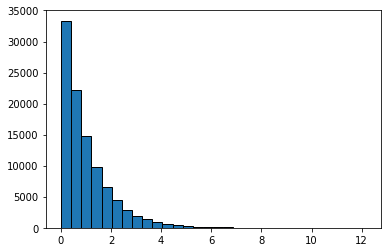

In [48]:
import random
from math import log

def t_inv(u, lamb):
    return - lamb * log(1-u)

def rand(n):
    numbers = []
    for i in range(n):
        y = t_inv(u = random.random(), lamb = 1)
        numbers.append(y)
    return numbers

plt.hist(rand(100000), bins=30, ec="black")

#### Méthode combinée

Combine la méthode du rejet et de la transformée inverse.
On utilise la méthode du rejet avec une distribution arbitraire $g(x)$

Au lieu d'envelopper la fonction avec une ligne droite ($M$) _(cf. méthode du rejet)_, on enveloppe avec une fonction $M.g$ qui a à peu près la même forme que la fonction $f$.

- On multiplie $g(x)$ par $M$ tel que $Mg(x)$ "enveloppe" $f(x)$ càd:  $Mg(x) \geq f(x)$ sur l'intervalle.
- On génère $x, u$ **avec** _$x$ selon $g$_ **et** _$u$ uniforme_ ($\in [0,1]$).
- On obtient des couples de points $(x,y) = (x, u M g(x))$
- On garde $x$ le couple $(x,y)$ se situe sous la courbe $f(x)$ càd: $u \leq \frac{f(x)}{Mg(x)}$

<img src="https://datasciencechalktalk.files.wordpress.com/2019/09/image-171.png" width="500px">

**exemple**:


On veut générer des nombres aléatoires ayant une distribution selon la fonction suivante : 

$$f(x) = \frac{sin^2(x)}{x} \quad \text{appartenant à l'intervalle $[1, 20]$}$$

Or on sait que :

$$ sin^2(x) \leq 1$$

Donc on peut majorer $f$ avec la fonction suivante :

$$ g(x) = \frac{1}{x} $$

Avec la méthode du rejet, on majorait avec "une ligne droite de valeur $y = M$" et donc on ne devait pas calculer de transformée inverse. Dans notre cas, on majore avec une fonction $g$ qui est "semblable" à $f$ et donc on doit calculer sa transformée inverse afin de pouvoir prendre des nombres $y$ appartenant à cette distribution.

On calcule la transformée $T$ de $g$ :

$$ G(x) = \int_1^x \frac{1}{x'}dx' = ln(x) - ln(0) = ln(x) $$

Maintenant, il faut que G(x) soit compris entre $[0, 1]$. Typiquement, $G(x_min) = 0 et G(x_max) = 1$ car on utilise une distribution uniforme $\in [0, 1]$ sur son inverse. Le problème est que ce n'est pas le cas : 

- $G(1) = ln(1) = 0$ => ok
- $G(20) = ln(20) \approx 3 > 1$ => ko

On va normaliser $g$ en le multipliant par un certain $\lambda$ :

$$ \lambda g(x) = \frac{\lambda}{x} $$

On recalcule sa transformée :

$$ G(x) = \int_1^x \frac{\lambda}{x'}dx' = \lambda ln(x) $$

On observe que :

$$ G(20) = \lambda ln(20) \implies \lambda = \frac{1}{ln(20)} \implies G(20) = 1 $$

On peut enfin chercher l'inverse de la transformée : 

$$G(x) = \frac{ln(x)}{ln(20)} = u \implies u ln(20) = ln(x) \implies e^{u ln(20)} = x = G^{-1}(x) = T(u) $$

On a donc : 

$$ T(u) = e^{uln(20)} = e^{ln(20^u)} = 20^u$$

Il ne reste plus qu'à trouver $M$. Puisque $f(x) < Mg(x)$ :

$$ \frac{sin^2(x)}{x} \leq \frac{1}{x} \leq M \frac{\lambda}{x} \implies M = \frac{1}{\lambda} $$

On gardera donc le nombre $x$ généré si et seulement si :

$$ u \leq \frac{f(x)}{Mg(x)} = \frac{f(x)}{(1/ \lambda) * (\lambda/x)} = \frac{f(x)}{x} $$


efficacité: 12.77%


(array([3.487e+03, 2.722e+03, 1.927e+03, 1.368e+03, 9.320e+02, 6.800e+02,
        4.420e+02, 2.880e+02, 1.470e+02, 6.100e+01, 2.100e+01, 4.000e+00,
        1.000e+00, 1.300e+01, 1.900e+01, 2.600e+01, 4.700e+01, 5.700e+01,
        5.700e+01, 5.700e+01, 5.800e+01, 4.900e+01, 4.000e+01, 2.400e+01,
        2.100e+01, 1.800e+01, 1.200e+01, 6.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+01, 8.000e+00, 1.000e+01,
        1.300e+01, 1.500e+01, 1.800e+01, 1.700e+01, 6.000e+00, 9.000e+00,
        9.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 6.000e+00, 6.000e+00, 5.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

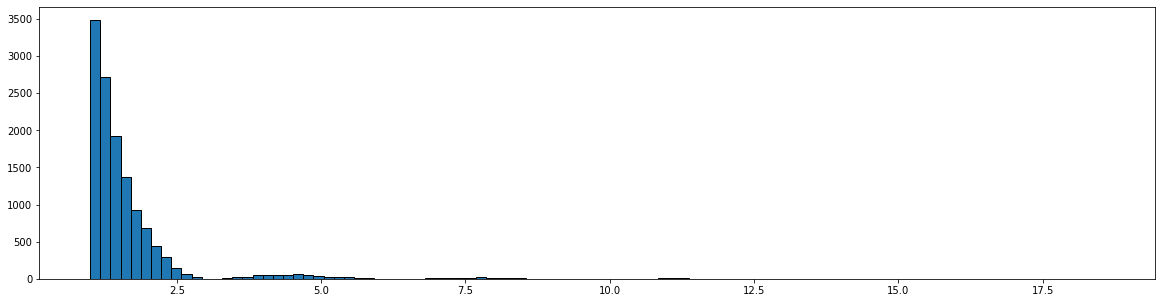

In [58]:
import math
import random
import matplotlib.pyplot as plt

def inv_transform():
    u = random.random()
    T = 20**u
    return T

def f(x):
    return (math.sin(x))**2 / x

def rejection_with_transform(f, n, a, b):
    numbers = []
    accepted = 0
    for i in range(n):
        x = inv_transform()
        u = random.random()
        
        # on garde le nombre
        if u <= (f(x) / x):
            accepted += 1
            numbers.append(x)
    
    return numbers, accepted / n
    
numbers, eff = rejection_with_transform(f, 100000, 1, 20)

print(f"efficacité: {eff * 100:.2f}%")
plt.hist(numbers, bins = 100, ec = "black")